Created by Jason Chen, under Professor Krzysztof Fidkowski

# Problem Statement
The quality and runtime of a CFD solution is highly dependent on the mesh, and although good methods exist to automate mesh refinement, initial mesh generation techiques remain poor at capturing where refinement should take place, and to what degree. The goal of this project is to replicate and build off of work done by [Ohja, Chen, and Fidkowski](https://websites.umich.edu/~kfid/MYPUBS/Ojha_Chen_Fidkowski_2022.pdf), which performs anisotropic mesh generation on simple 2D airfoils. The subsequent mesh optimization process (typically done by routines like MOESS) is out of the scope of this project.

| ![run1_mesh.png](/home/jasonyc/code/research/ml-meshing/images/run1_mesh.png) | 
|:--:| 
| **Figure 1:** A near-optimally meshed airfoil used for training. |

# Background
Anisotropy, meaning when the elements in the mesh are noncongruent, is represented mathematically by a **metric field**. A metric field can be thought of as a measuring stick—it defines distances between points in space, or more precisely (paraphrasing from the cited paper above), for a metric field $M$ and a point in space $\vec{x}$, $M(\vec{x})$ measures the distance from $\vec{x}$ to a point infinitesimally far away, $\vec{x} + \delta \vec{x}$.

Since our problem is in 2 dimensions, $M$ is represented by a 2x2 SPD (symmetric positive definite) matrix. To break down this definition:

- **Symmetric**: $M = M^T$
- **Positive Definite**: The eigenvalues of the metric are all real and positive, meaning the matrix's behavior is "well-defined" and thus there are no directions $x$ where $x^T M x \leq 0$

## Measuring Distance
As an aside, we'll dive into why and how $x^T M x$ represents a distance. I've taken Math 419 but I found that I needed to brush up on linear algebra for this. Feel free to skip this section.

Firstly, how do we define the notion of length for a vector? We take the dot product of the vector with itself:
$$ \vec{x} \cdot \vec{x} = \lVert {\vec{x}} \rVert^2 $$
We can rewrite this:
$$ x^T x = x^T I x = \lVert {\vec{x}} \rVert^2 $$
Here, $I$ is the identity matrix. Thus, it implies that a metric such that $M = I$ is our "typical" notion of distance, without the local stretching.

The expression $x^T M x$ is also called a **quadratic form**:
$$ x^T M x = \sum_{i,j}^{} M_{i,j} x_i x_j $$
which combines the components of $x$ using $M$, and can be used to represent a polynomial using matrices. For example, given that:
$$ M = \begin{bmatrix}
3 & -2 \\
-2 & 7
\end{bmatrix} $$
we can compute:
$$
x^T M x = \begin{bmatrix} x_1 & x_2 \end{bmatrix} \begin{bmatrix}
3 & -2 \\
-2 & 7
\end{bmatrix} \begin{bmatrix} x_1 \\ x_2 \end{bmatrix}
$$
$$
= 3 x_1 x_1 - 2 x_1 x_2 - 2 x_2 x_1 + 7 x_2 x_2 = 3 x_1^2 - 4 x_1 x_2 + 7 x_2^2
$$

We can see that if $M$ is a diagonal matrix, i.e. $M = \lambda_i I$, the cross product term (involving both $x_1$ and $x_2$) does not exist and we are left with the square of the components times $\lambda_i$. In other words, each component $x_i$ is scaled by the corresponding eigenvalue $\lambda_i$:
$$ x^T M x = \lambda_1 x_1^2 + \lambda_2 x_2^2 + ... $$

In the more general case, take an SPD matrix $M$. The eigenvalues of $M$ represent the magnitude of scaling (shrinking or stretching, as seen above), and will not result in negative distances since $\lambda_i > 0$ by definition of SPD. The eigenvectors will represent the principal directions of this scaling. 

We can show this mathematically through diagonalization. Since $M$ is symmetric, we can diagonalize it:
$$ M = SDS^{-1} $$
More specifically, because $M$ is real and symmetric, $S$ is an orthogonal matrix, i.e. its columns contain linearly independent vectors (eigenvectors of $M$) and $S$ exhibits the property that $S^{-1} = S^T$. $D$ is a diagonal matrix with each entry being the eigenvalues of $M$.

Next, we can express $x$ in the new basis (defined by the eigenvectors of $M$) with:
$$ y = S^T x $$
This is a simple change of basis. Since each column of S contains eigenvectors, $S^T x$ essentially computes the dot product of each basis vector with $x$, and so $y$ represents $x$ in the new basis. We can then substitute $x = Sy$ in, noting that $S^T S = S^{-1} S = I$:
$$ x^T M x = (Sy)^T (S D S^{-1}) (Sy) = y^T S^T S D S^{-1} S y = y^T D y$$
Since $D$ is diagonal, this simplifies to:
$$ x^T M x = y^T D y = \sum_{i=1}^{n} \lambda_i y_i^2 $$
and so the quadratic form $x^T M x$ measures a **generalized squared distance** in the transformed space.

## Metric Fields Applied to Meshing
Since a metric field represents stretching along the axes of its eigenvectors, if we plot a set of points a unit distance away from a certain point $\vec{x}$ with metric $M$, we will get an ellipse. The direction of the major and minor axes are given by the eigenvectors, and the length of each axis (stretching) is the inverse square root of the corresponding eigenvalue. This means we can visualize the metric fields given a mesh, but first, we'll need to understand how we are encoding the mesh data.

### Mesh Data Format
Meshes are given in `.gri` files under the `meshes/` directory. Within these files, the first section (first couple hundred lines) give two numbers separated by a space, which are $(x,y)$ pairs of coordinates representing a node. This section ends once a following line in the file looks something like this: `52 2 Outflow`. This is a boundary label, which calls out edges that define boundary conditions when running FEA/CFD, but are not necessarily useful right now. The section that defines our elements follows a label that looks like: `1670 1 TriLagrange`. "Trilagrange" is the key word to look out for here, and we can note that the data following this label is a set of three integers. Each integer corresponds with a node, which was numbered (indexed) when we ingested the first section at the beginning of the file. These three nodes together define a triangular element.

## Plotting Ellipses
So, we can ingest the `.gri` file and plot the mesh using `plotmesh.py` (implementation and derivation will be skipped here since it's pretty tedious but relatively straightforward). To plot the metric field ellipses corresponding with each element, we perform the following routine:

**Assumptions**

- The metric field is constant across an element
- Each node of an element is a unit distance (1) away from each other, i.e. the edges (denoted $\delta \vec{x}$) have length 1 as defined by the local metric field $M$

**Routine**

- Go through all elements
- For each element, get the (x,y) coordinates of each of its 3 nodes
- Compute the edge vectors by simple vector subtraction $\delta \vec{x}$
- For each edge, we have the equation $1 = \delta \vec{x}^T M \delta \vec{x}$ where M is the unknown 2x2 metric field with entries $(a, b, b, c)$
- Since we have three edges, we will have 3 equations and 3 unknowns, and solve
- Once we have the metric field, compute its eigenvalues and eigenvectors, and plot the ellipse

The code below is a copy of the file `plotmesh.py`, for demonstration purposes.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse
from readgri import readgri


def plot_metric_fields(mesh: dict, ax: plt.Axes):
    """
    Plot the metric field ellipses. This function relies in the dictionaries
    for elements and vertices to already be filled by the `readgri.py` module.
    """
    V = mesh['V']; E = mesh['E']
    for i, element in enumerate(E):
        # Each vertex contains three (x,y) tuple coordinates
        verts = [V[v_ind] for v_ind in element]
        centroid = np.asarray([np.mean([v[0] for v in verts]),
                               np.mean([v[1] for v in verts])])
        delta_x = [verts[i] - verts[i-1] for i in range(len(verts))]
        # Assemble a matrix of the quadratic form for each edge
        A_mat = [[vec[0]**2, 2*vec[0]*vec[1], vec[1]**2] for vec in delta_x]
        A_mat = np.reshape(np.asarray(A_mat), (3,3))
        # Solve the system of equations by inverting A
        soln_abc = np.matmul(np.linalg.inv(A_mat), np.ones((3,1))).flatten()
        M_mat = np.array([[soln_abc[0], soln_abc[1]],
                          [soln_abc[1], soln_abc[2]]])
        # Extract eigenvalues and eigenvectors and plot
        eig_vals, eig_vecs = np.linalg.eig(M_mat)
        major_ax_i = np.argmax(eig_vals)
        minor_ax_i = int(not major_ax_i)
        axes_scales = np.zeros(len(eig_vals))
        axes_scales[major_ax_i] = eig_vals[major_ax_i]**(-1/2)
        axes_scales[minor_ax_i] = eig_vals[minor_ax_i]**(-1/2)
        # Angle of the major axis with the global (plotting) coordinate frame
        angle_major = np.arctan2(eig_vecs[major_ax_i][1],
                                 eig_vecs[major_ax_i][0])
        if i % 10 == 0:  # Only plotting every 10th ellipse here
            ellipse = Ellipse(centroid, axes_scales[major_ax_i],
                              axes_scales[minor_ax_i],
                              angle=-angle_major*180/np.pi,
                              facecolor='blue', alpha=0.5)
            ax.add_patch(ellipse)


def plotmesh(mesh: dict):
    """
    Plot the mesh itself. This also calls the metric field plotting function.
    """
    V = mesh['V']; E = mesh['E']; BE = mesh['BE']
    fig, ax = plt.subplots(dpi=300)
    plt.triplot(V[:,0], V[:,1], E, 'k-')
    for i in range(BE.shape[0]):
        plt.plot(V[BE[i,0:2],0], V[BE[i,0:2],1], linewidth=0.1, color='black')
    plot_metric_fields(mesh, ax)
    ax = plt.gca()
    ax.set_xlim([-1, 2])
    ax.set_ylim([-2, 2])
    plt.tick_params(axis='both')
    plt.show()
    plt.close(fig)

Now, we'll run the plotting routine. We're ingesting the `.gri` file specified with `file_name`, which is the same file as shown in Figure 1.

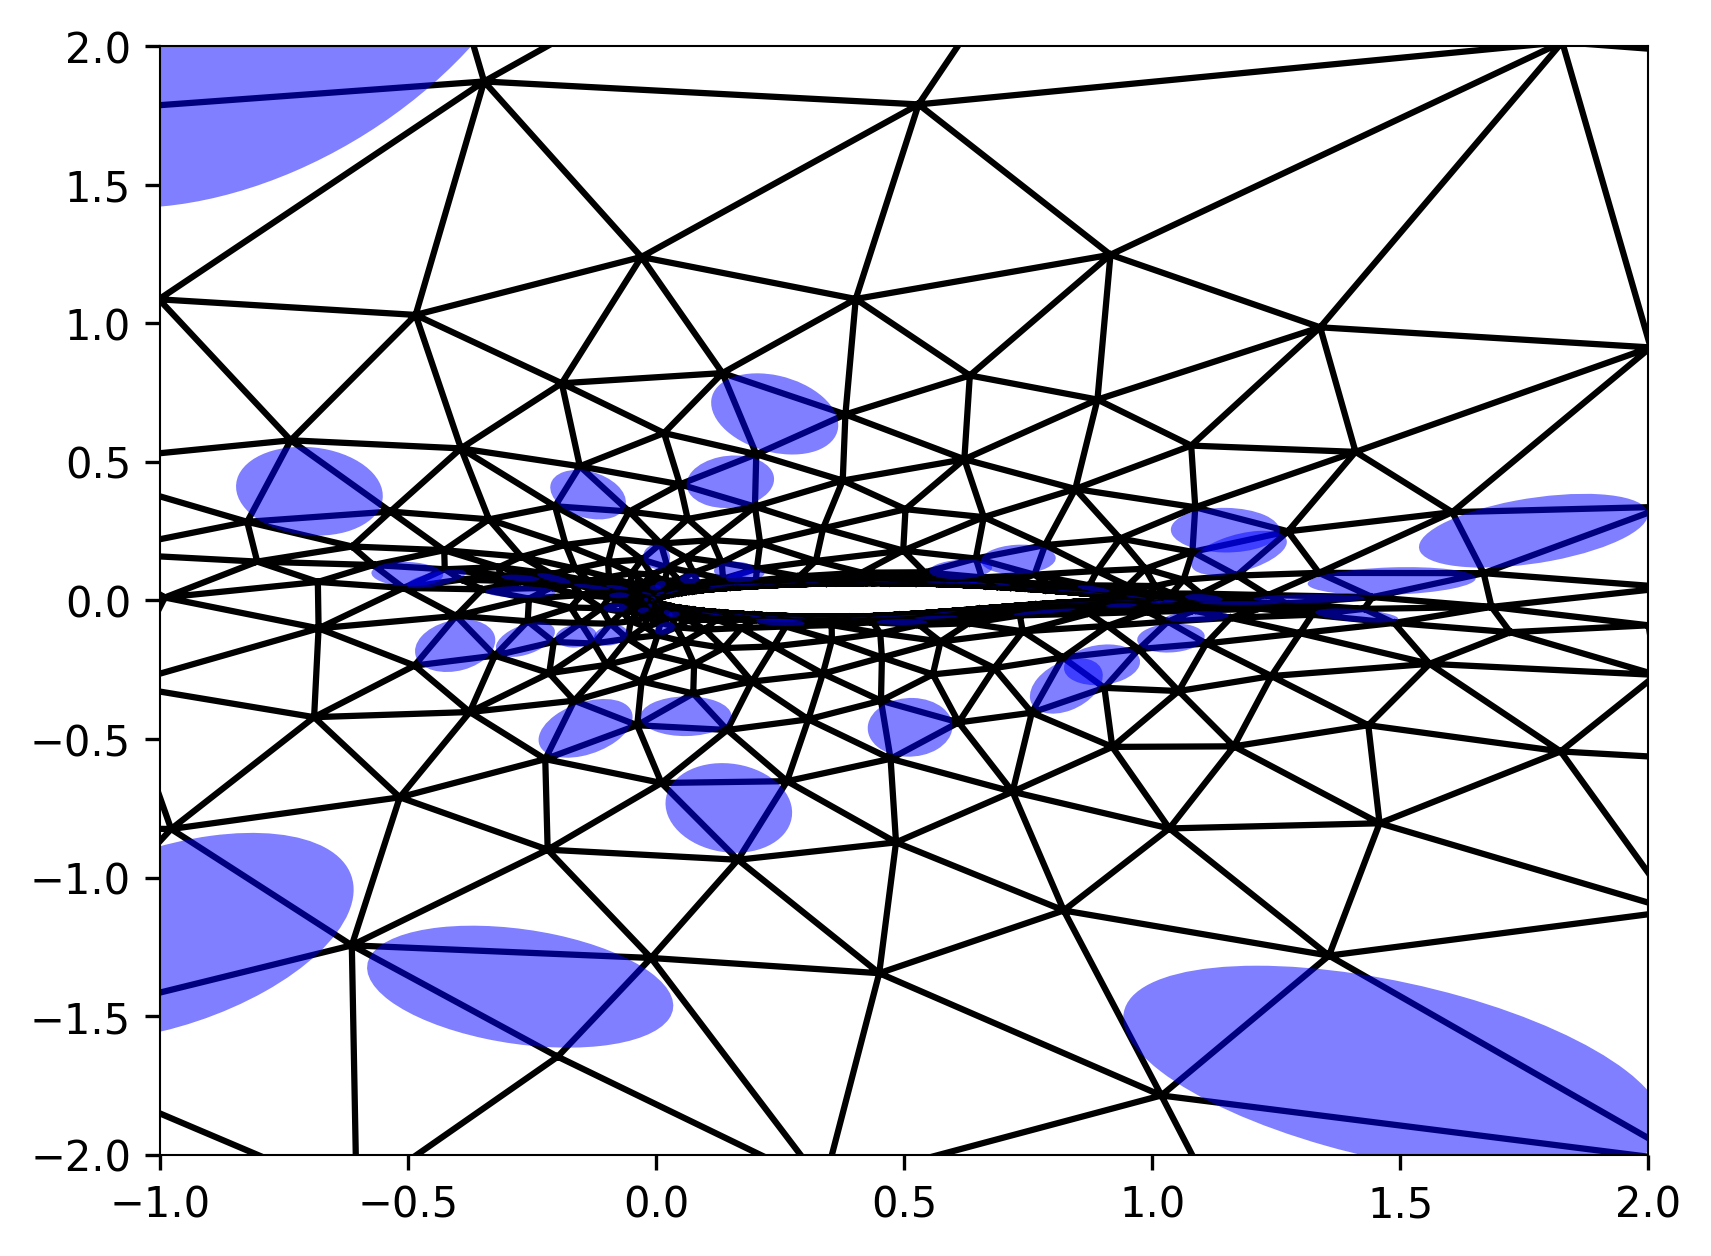

In [7]:
file_name = 'meshes/run1.gri'
plt.style.use('fast')
mesh = readgri(file_name)
plotmesh(mesh)

# Approach
The general approach for tackling this problem is to supply a neural network with training data that pairs the location of a mesh element (x, y, distance from the wall of the airfoil) with the desired metric field. 


## Tools
The python packages required for this project are listed under `requirements.txt` and can be installed with:
```bash
pip3 install -r requirements.txt
```
I chose to use [PyTorch](https://pytorch.org/) because it is well-known for being Pythonic, has plenty of supporting documentation and tutorials, and is just as fast as any other ML library (uses Tensorflow C/C++ backend).


## Neural Network Architecture
The architecture of the neural network replicates what was done in the cited paper. There is a **spatial network**, which takes 3 inputs: the (x,y) position of the centroid of an element, as well as the average wall distance of each of its nodes, and maps it to 10 output neurons. There is also a **parameter network**, which also processes 3 inputs: the natural logarithm of the Reynolds number (taking the log as a way for normalization, reducing the magnitude of this number), Mach number, and angle of attack in radians, and maps these to 10 output neurons. The outputs of these networks are then combined and passed through more hidden layers until a final output layer of 3 neurons.

| ![nn_graphic.png](/home/jasonyc/code/research/ml-meshing/images/nn_graphic.png) | 
|:--:| 
| **Figure 2:** The neural network architecture. |

The output of the entire architecture are the a, b, c entries of the **matrix logarithm** of the metric field. This is done for two reasons: first, like for Reynolds number, doing so reduces the magnitude of the network output. Secondly, because the output is symmetric by nature (only allowing 3 outputs), taking the matrix exponential of this output guarentees that the resulting matrix is an SPD matrix (i.e. a valid metric field).

## Training Data
The first step is to compile and format the training data. As mentioned in the previous section, the bulk of element information is supplied through `.gri` files. Under `meshes/` and `fine_meshes/`, each `.gri` file represents the same NACA airfoil under the same flow conditions (Reynolds number of $1 \times 10^6$, Mach number of $0.25$), but at different angles of attack ($\alpha$). The $\alpha$ varies linearly based on the run number indicated in the file name, so `run1` is at -5 degrees, `run2` is at -4 degrees, ..., `run16` is at 10 degrees. This adds some variance to the meshes, but since the geometry and position of the airfoil in the middle is constant, the general relationship between mesh refinement and the position of a metric field should be consistent and able to be learned.

Wall distance information is found under `fine_walldist/`, and each `.txt` file is numbered corresponding to the `.gri` file it supplements. Inside the wall distance files, each set of three floats are the wall distances for each node in an element. We only care about the wall distance of the entire element, so in the training process we take the average of these three values. Each set of distance measurements is index-matched with its element in the corresponding `.gri` file, so for example, the first three distances correspond with the zeroth indexed element, and so on.

Using our technique to back out the metric field from a given mesh when plotting ellipses, we can now go through all mesh files and produce the metric field at each element. The way we store this training data is through a Pytorch `Dataset` object, which is just a convenient wrapper that allows batching, shuffling, and splitting between training and evaluation data. In our case, we inherit the `Dataset` object and define our own custom superclass, `MeshDataset`, so we can customize its behavior.

The `MeshDataset` object only really needs to implement three methods: the constructor, `__len__()`, and `__getitem__()`. In the constructor, we want to set the internal data structure that stores all of our data. In my case, I chose to use a [Pandas DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html) because it works efficiently and intuitively with tabular data (you can specify column labels, do splicing operations, etc.) and stored it as a member variable, `self.data`. The `__len__()` method is pretty self-explanatory, as it just needs to return the length of our DataFrame. `__getitem__()` defines how PyTorch will extract a single tuple (a feature, label pair) from our internal data structure, given an index. So in our case, we just need to use `self.data.iloc[index]` to query the row, representing the element corresponding with the index. To return the (feature, label) pair, we take note of how the DataFrame is constructed:

|               |  x  |  y  | wall_dist | ln(Re) | Mach | $\alpha$ (rad) |  a   |  b   |  c   |
| :------------ | :-: | :-: | :-------: | :----: | :--: | :------------: | :--: | :--: | :--: |
| Element 0     | 0.0 | 2.1 |    0.23   |  13.81 | 0.25 |     -0.087     | 9.50 | 0.41 | 24.1 |
| Element 1     | 0.1 | 3.5 |    0.45   |  13.81 | 0.25 |     -0.069     | 13.2 | -8.4 | 87.3 |
| ...           | ... | ... |    ...    |  ...   | ...  |     ...        | ...  | ...  | ...  |

This means to extract the features (what the network sees), we take the first 6 (`:6`) items in the row, while the labels (what the correct answer is for the network's prediction) are the last three (`6:`) items.


> NOTE: The code below is simplified from `basic_ml_model.py`, which is the main script used for this project. Notably, it excludes logic used to support data loading and saving. Logic using `self.data_split_indices` is also excluded, since this is just a dictionary used during plotting and debugging (so that we can discern when a `.gri` file ends and another begins within the large `self.data` DataFrame).

In [8]:
from torch.utils.data import Dataset
import numpy as np
import pandas as pd
import os

class MeshDataset(Dataset):
    def __init__(self):
        super(MeshDataset, self).__init__()
        self.reynolds = float(np.log(1e6))
        self.mach = 0.25
        self.files = ['fine_meshes/run1.gri', 'fine_meshes/run2.gri']
        self.data = self.create_data()

    def create_data(self) -> pd.DataFrame:
        data = []
        for file in self.files:
            run_str = os.path.basename(file).split('.')[0]
            run_num = int(run_str[3:])
            mesh = readgri(file)
            vertices = mesh['V']; elements = mesh['E']
            # Preprocess wall distance information
            dist_f_name = 'walldistance' + str(run_num) + '.txt'
            dist_path = os.path.join('fine_walldist', dist_f_name)
            wall_dists = []
            with open(dist_path, 'r') as dist_file:
                line = dist_file.readline()
                while line:
                    if line[0] == '%': 
                        pass
                    elif len(line.split()) > 1:
                        avg_d = np.mean([float(dist_file.readline()) 
                                         for _ in range(3)])
                        wall_dists.append(avg_d)
                    line = dist_file.readline()
            assert(len(wall_dists) == len(elements))

            for i, element in enumerate(elements):
                verts = [vertices[v_ind] for v_ind in element]
                centroid = [np.mean([v[0] for v in verts]),
                            np.mean([v[1] for v in verts])]
                # Combine spatial and parameter information into a feature
                params = [self.reynolds, self.mach, np.deg2rad(run_num-6)]
                feature = centroid + [wall_dists[i]] + params
                # Find the correct A, B, and C terms in our metric field
                delta_x = [verts[i]-verts[i-1] for i in range(len(verts))]
                # All delta x are a unit length L=1 apart, solve for M
                A_mat = [[vec[0]**2, 2*vec[0]*vec[1], vec[1]**2]
                         for vec in delta_x]
                A_mat = np.reshape(np.asarray(A_mat), (3,3))
                metric_abc = np.matmul(np.linalg.inv(A_mat),
                                       np.ones((3,1))).flatten()
                label = list(metric_abc)
                # Append to data structure
                data.append(feature + label)
        return pd.DataFrame(data, columns=DATA_KEYS)

    def __len__(self):
        return len(self.data)
    
    def __getitem__(self, idx):
        """Returns a tuple (feature, label) from internal data"""
        row = tuple(self.data.iloc[idx])
        sample = (row[:6], row[6:])
        if self.transform:
            sample = self.transform(sample)
        return sample

## Using the Current Script
This report will dive into the derivations and reasoning for how the model works, but if you're just interested in running (training and evaluating) the model, this section will explain the functionality of `basic_ml_model.py`.

To run, simply:
```bash
python3 basic_ml_model.py
```
There are a couple command line arguments you can use depending on the use case.

- `--export_data`: including this flag will save any generated training data to a `.csv` file so that next time, the training data can be read in CSV format (faster) instead of going through the metric field derivation from raw `.gri` data
- `--generate_data`: including this flag will explicitly tell the script to generate new training data from the specified data source (either `fine_meshes/` or `meshes/`), while excluding this flag tries to pull `.csv` data from `data/` by default
- `--data_path`: specifies the path for training data, the default value is `data/training_data.csv`
- `--plot`: whether or not to plot the ellipses the model is predicting at the end of each epoch, for debugging purposes
- `--interactive`: another debugging tool, but this time the user can set a visual debugging breakpoint inside the `plot_individual_loss()` helper and step through each individual metric field prediction and loss calculation

So for example, if I wanted to generate new data and save it, while plotting the results:
```bash
python3 basic_ml_model.py --export_data --generate_data --plot
```
Or, simply:
```bash
python3 basic_ml_model.py -egp
```